### 1 什么是变分自编码器?
参考论文：《计算机学报》2019.1  自编码神经网络理论及应用综述  袁非牛  
学习视频：https://www.bilibili.com/video/BV15E411w7Pz?from=search&seid=3390808955972515947   
原始自编码器：    
自编码器中，需要输入一个原始图片，原始图片经过编码之后得到一个隐向量，隐向量解码产生原图片对应的图片。在这种情况下，只能生成原图片对应的图片而无法任意生成新的图片，因为隐向量都是原始图片确定的。  

KL散度：   
两个概率分布之间的KL散度只是衡量它们相互之间有多大的分歧。 最小化KL散度意味着优化概率分布参数（μ和σ），使其与目标分布的概率分布参数非常相似。 

变分自编码器（Variational AutoenEoder,VAE）：  
可以在遵循某一分布下随机产生一些隐向量来生成与原始图片不相同的图片，而不需要预先给定原始图片。为了达到这个目的，需要在编码过程增加限制，使得生成的隐向量能够粗略地遵循标准正态分布。实际情况下，需要在模型的准确率与隐向量服从标准正态分布之间做一个权衡。模型的准确率就是指解码器生成的图片与原图片的相似程度；隐向量分布采用KL散度来衡量与标准正态分布之间的误差。两部分误差之和作为总体的误差来优化。VAE使用了重参数化这个技巧来KL散度的计算。编码器不再是生成一个隐向量，而是生成正态分布的均值和标准差（若是多维正态分布，会有多个均值和标准差），然后根据这两个统计量下的分布抽样生成隐含向量。因为我们想要使得隐含向量服从标准正态分布，即均值为0，标准差为1，通过优化KL散度来使得分布逼近标准正态分布。  

简单描述：
Encoder 从图像中采样，产生 Latent space的概率分布，the decoder在 Latent space中采样该点，然后返回一个生成的图像。所以对于一张给定的图像来说，Encoder产生一个分布，在Latent space中该分布中采样出一个点出来，然后将该点输入到 Decoder当中，产生一个图像。

原文链接：https://blog.csdn.net/qq_33948796/article/details/89217300
参考：https://blog.csdn.net/winycg/article/details/90318371  

### 2 使用变分自编码器注意的情况
1 损失函数：两部分组成，下图，重构损失和KL散度，重构损失衡量输入和输出的误差，KL散度衡量概率分布误差。  
2 KL散度的数学计算公式：log函数可能出现负值，使用指数函数代替。  
3 由于网络采用的是随机采样，无法使用反向传播算法，引入"重新参数化reparameterization"技巧，先通过标准正态分布采样再通过一个变换获取对隐变量的采用。  
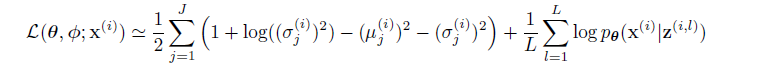

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


In [4]:
#  Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 500
num_latent = 15

In [5]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cpu')

In [8]:
class VariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent):
        super(VariationalAutoencoder, self).__init__()
        
        ### ENCODER
        self.hidden_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features):
        x = self.hidden_1(features)
        x = F.leaky_relu(x, negative_slope=0.0001)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.linear_3(encoded)
        x = F.leaky_relu(x, negative_slope=0.0001)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features):
        
        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        
        return z_mean, z_log_var, encoded, decoded

In [9]:
torch.manual_seed(random_seed)
model = VariationalAutoencoder(num_features,
                               num_hidden_1,
                               num_latent)
model = model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | Cost: 70481.7266
Epoch: 001/050 | Batch 050/469 | Cost: 27138.1426
Epoch: 001/050 | Batch 100/469 | Cost: 22832.0684
Epoch: 001/050 | Batch 150/469 | Cost: 19491.6309
Epoch: 001/050 | Batch 200/469 | Cost: 18725.3887
Epoch: 001/050 | Batch 250/469 | Cost: 18072.8945
Epoch: 001/050 | Batch 300/469 | Cost: 16631.3184
Epoch: 001/050 | Batch 350/469 | Cost: 17135.7617
Epoch: 001/050 | Batch 400/469 | Cost: 16397.8223
Epoch: 001/050 | Batch 450/469 | Cost: 16062.2891
Time elapsed: 0.39 min
Epoch: 002/050 | Batch 000/469 | Cost: 16575.0000
Epoch: 002/050 | Batch 050/469 | Cost: 15454.1328
Epoch: 002/050 | Batch 100/469 | Cost: 15663.3242
Epoch: 002/050 | Batch 150/469 | Cost: 15733.0957
Epoch: 002/050 | Batch 200/469 | Cost: 15152.5859
Epoch: 002/050 | Batch 250/469 | Cost: 15332.5166
Epoch: 002/050 | Batch 300/469 | Cost: 15415.0879
Epoch: 002/050 | Batch 350/469 | Cost: 15640.2793
Epoch: 002/050 | Batch 400/469 | Cost: 14797.8105
Epoch: 002/050 | Batch 450/

Epoch: 032/050 | Batch 100/469 | Cost: 13448.6699
Epoch: 032/050 | Batch 150/469 | Cost: 12849.5850
Epoch: 032/050 | Batch 200/469 | Cost: 13102.7617
Epoch: 032/050 | Batch 250/469 | Cost: 12922.1631
Epoch: 032/050 | Batch 300/469 | Cost: 13219.3906
Epoch: 032/050 | Batch 350/469 | Cost: 13001.8701
Epoch: 032/050 | Batch 400/469 | Cost: 13145.3682
Epoch: 032/050 | Batch 450/469 | Cost: 13224.6113
Time elapsed: 14.04 min
Epoch: 033/050 | Batch 000/469 | Cost: 12938.8848
Epoch: 033/050 | Batch 050/469 | Cost: 13252.2090
Epoch: 033/050 | Batch 100/469 | Cost: 13185.9961
Epoch: 033/050 | Batch 150/469 | Cost: 13074.0596
Epoch: 033/050 | Batch 200/469 | Cost: 13002.2461
Epoch: 033/050 | Batch 250/469 | Cost: 13009.4639
Epoch: 033/050 | Batch 300/469 | Cost: 12901.1055
Epoch: 033/050 | Batch 350/469 | Cost: 13574.0117
Epoch: 033/050 | Batch 400/469 | Cost: 13072.9824
Epoch: 033/050 | Batch 450/469 | Cost: 13273.9912
Time elapsed: 14.48 min
Epoch: 034/050 | Batch 000/469 | Cost: 12967.0166
Ep

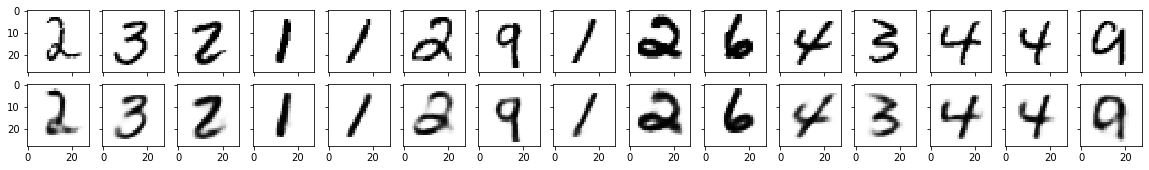

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

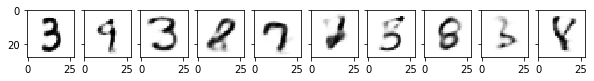

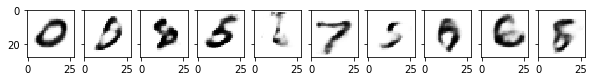

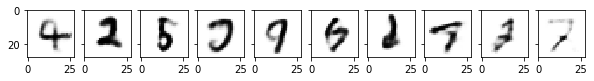

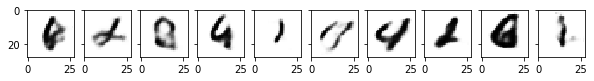

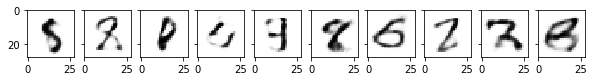

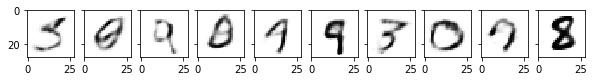

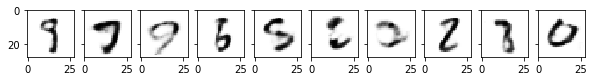

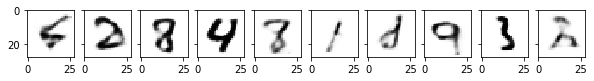

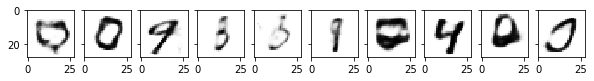

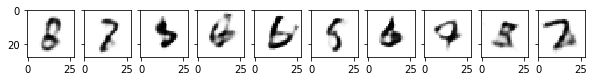

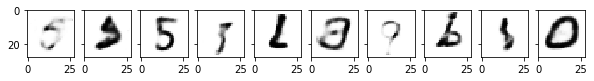

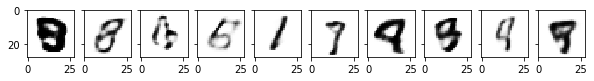

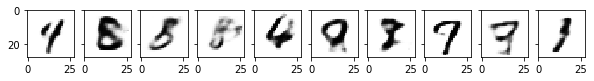

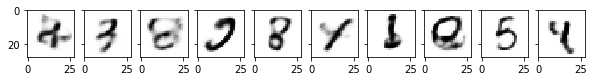

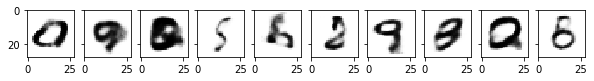

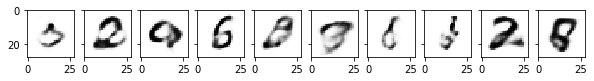

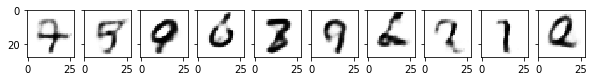

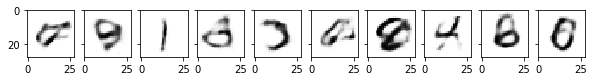

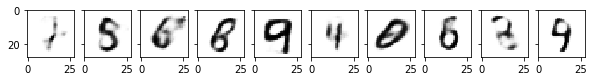

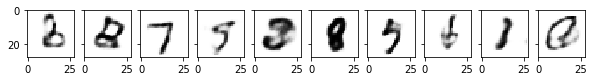

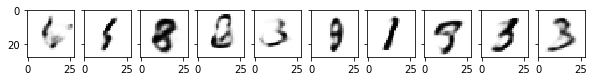

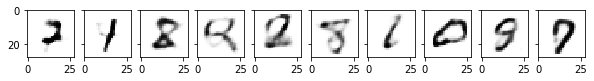

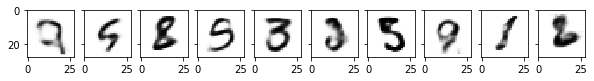

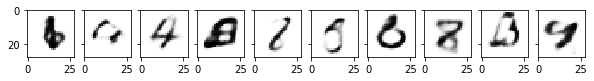

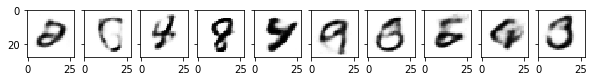

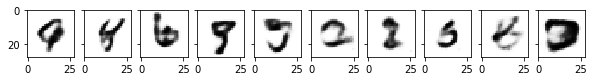

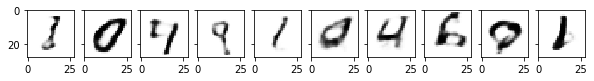

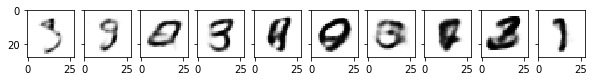

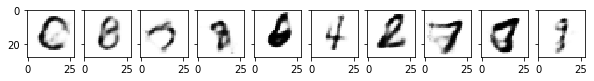

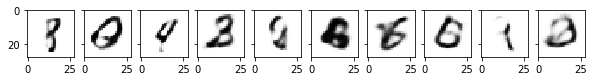

In [13]:
for i in range(30):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')
        
    plt.show()